In [67]:
from datasets import load_dataset
ds = load_dataset("KGraph/FB15k-237")
import json

with open("entity2wikidata.json", "r") as f:
    mid_info = json.load(f)

mid_to_name = {mid: data["label"] for mid, data in mid_info.items()}

In [68]:


import csv

from rdflib import Graph, URIRef
import re, unicodedata
# 1. Criar o grafo RDF
kg = Graph()
SPORT = {
    "/sports/",
    "/soccer/",
    "/olympics/",
}
def clean_name(name):
    # remover acentos
    name = unicodedata.normalize('NFKD', name).encode('ASCII', 'ignore').decode()
    # substituir espaços por _
    name = name.replace(" ", "_")
    # remover tudo que não for letra, número ou _
    name = re.sub(r"[^a-zA-Z0-9_]", "", name)
    return name

# 2. Adicionar as triplas do dataset
for item in ds['train']:
    parts = item['text'].split("\t")
    if len(parts) != 3:
        continue
    
    head, relation, tail = parts
    if not relation.startswith(tuple(SPORT)):
        continue
    head_name = mid_to_name.get(head, head)
    tail_name = mid_to_name.get(tail, tail)
    head = clean_name(head_name)
    tail = clean_name(tail_name)

    # criar URIs para cada elemento
    head_uri = URIRef(head)
    relation_uri = URIRef(relation)
    tail_uri = URIRef(tail)
    
    kg.add((head_uri, relation_uri, tail_uri))



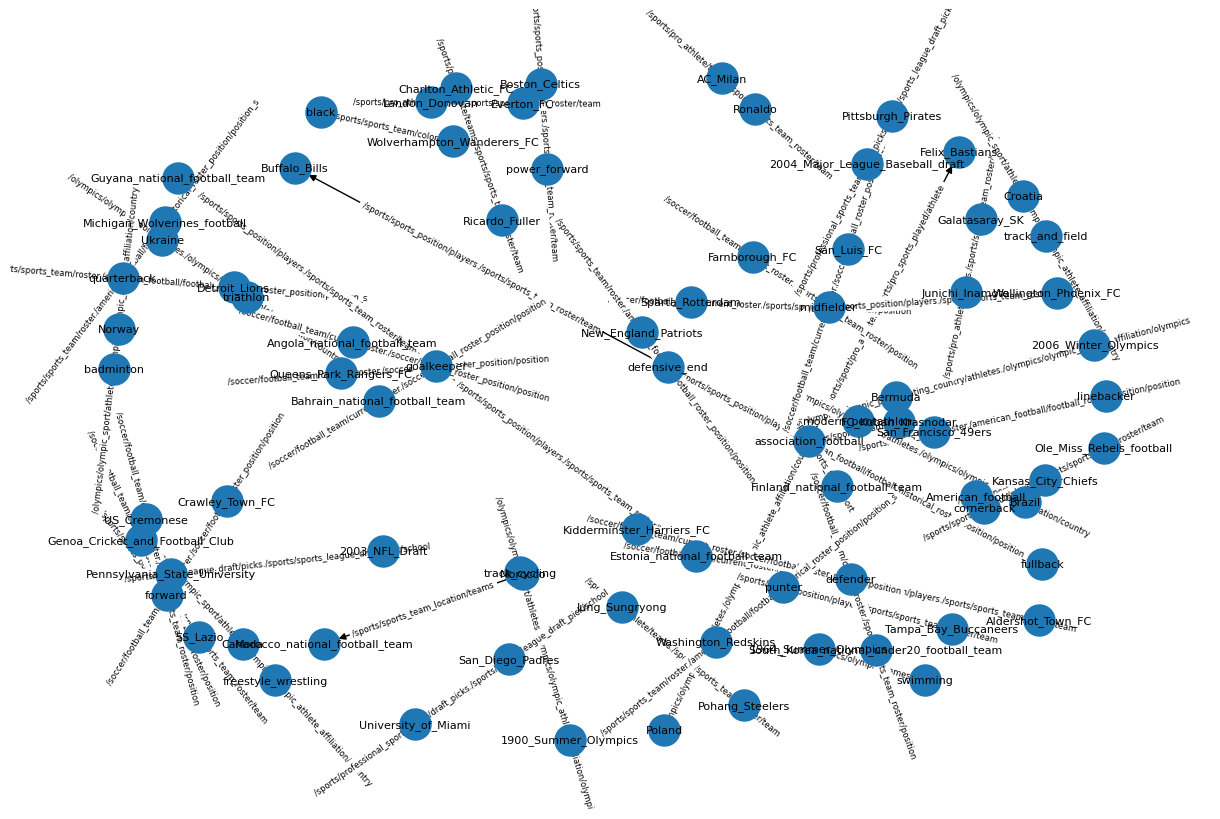

In [69]:
import networkx as nx
subgraph = list(kg)[:50]  # 50 triplas
import matplotlib.pyplot as plt

# Converter o RDFLib Graph para NetworkX
G = nx.DiGraph()

for s, p, o in subgraph:
    G.add_edge(str(s), str(o), label=str(p))
    

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.3)
nx.draw(G, pos, with_labels=True, node_size=500, font_size=8)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(s, o): p for s, o, p in G.edges(data='label')}, font_size=6)
plt.show()